# genetic k-means

In [51]:
# generating sample dataset
from sklearn.datasets import make_blobs

num_clusters = 4
num_features = 3
num_samples = 400
X, y = make_blobs(n_samples=num_samples,
                  centers=num_clusters,
                  n_features=num_features,
                  random_state=42)

In [ ]:
# define functions for gka

import numpy as np


def initialize_centroids(data: np.ndarray, k: int) -> np.ndarray:
    n_samples = data.shape[0]
    if k > n_samples:
        raise ValueError("The number of clusters (k) cannot be greater than the total number of samples.")
    
    random_indices = np.random.choice(n_samples, size=k, replace=False)
    centroids = data[random_indices]
    return centroids


def assign_clusters(data: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    data_expanded = data[:, np.newaxis, :] 
    centroids_expanded = centroids[np.newaxis, :, :]
    
    distances_sq = np.sum((data_expanded - centroids_expanded)**2, axis=2)
    
    cluster_indices = np.argmin(distances_sq, axis=1)
    
    return cluster_indices


def get_one_hot_from(data: np.ndarray, k: int, cluster_indices: np.ndarray) -> np.ndarray:
    n_samples = data.shape[0]

    w = np.zeros((n_samples, k), dtype=int)
    w[np.arange(n_samples), cluster_indices] = 1
    
    return w



def calculate_inertia(data: np.ndarray, centroids: np.ndarray, cluster_indices: np.ndarray) -> float:
    assigned_centroids = centroids[cluster_indices]
    inertia = np.sum((data - assigned_centroids)**2)
    return float(inertia)


def update_centroids(data: np.ndarray, w: np.ndarray, k: int, old_centroids: np.ndarray) -> np.ndarray:
    new_centroids = np.zeros_like(old_centroids)
    
    num_points_in_cluster = np.sum(w, axis=0)
    
    sum_cluster_points_matrix = np.dot(w.T, data)
    
    for j in range(k):
        if num_points_in_cluster[j] > 0:
            new_centroids[j] = sum_cluster_points_matrix[j] / num_points_in_cluster[j]
        else:
            new_centroids[j] = old_centroids[j]
            
    return new_centroids


def selection_tournament(individuals, fitnesses, population_size, group_size = 2):
    selected = np.zeros_like(individuals)
    selected_idx = []
    for i in range(len(individuals)):
        candidates = np.random.choice(population_size, size=group_size, replace=False)
        idx = candidates[np.argmax(fitnesses[candidates])]
        selected[i] = individuals[idx]
        selected_idx.append(idx)
    return selected, np.array(selected_idx)


def mutation_by_dist(population, centroids, num_samples, num_clusters, mutation_rate = 0.05):
    mutated_population = population.copy()

    for labels, c in zip(mutated_population, centroids):
        dists = np.linalg.norm(X - c[labels], axis=1)
        total_dist = np.sum(dists)
        mutation_probs = dists / total_dist
        num_mutations = int(np.ceil(mutation_rate * num_samples))
        mutation_indices = np.random.choice(num_samples, size=num_mutations, replace=False, p=mutation_probs)
        for idx in mutation_indices:
            current_label = labels[idx]
            other_labels = [l for l in range(num_clusters) if l != current_label]
            labels[idx] = np.random.choice(other_labels)

        
        while len(np.unique(labels)) < num_clusters:
            idx = np.random.choice(mutation_indices)
            current_label = labels[idx]
            other_labels = [l for l in range(num_clusters) if l != current_label]
            labels[idx] = np.random.choice(other_labels)

    return mutated_population


def one_step_k_means(population, data, default_centroids):
    new_generation = []
    for indi, old in zip(population, default_centroids):
        w = get_one_hot_from(data, num_clusters, indi)
        new_centroids = update_centroids(data, w, num_clusters, old)
        new_indi = assign_clusters(data, new_centroids)
        new_generation.append(new_indi)
    return np.array(new_generation)


In [52]:
max_generation = 10

# initialize population

population_size = 10
population = np.random.randint(0, num_clusters, size=[population_size, num_samples])
default_centroids = np.random.randn(*[population_size, num_clusters, num_features])

history = []

for gen in range(max_generation):
    
    # compute label matrix
    ws = [get_one_hot_from(X, num_clusters, label) for label in population]

    # compute centroids
    centroids = np.array([
        update_centroids(X, w, num_clusters, old) for w, old in zip(ws, default_centroids)
    ])

    # calculate fitness (-inertia)
    fitnesses = np.array([
        -calculate_inertia(X, means, idx) for means, idx in zip(centroids, population)
    ])

    # selection
    selected, selected_idx = selection_tournament(population,
                                                  fitnesses,
                                                  population_size)
    
    # mutation
    mutated = mutation_by_dist(selected, centroids[selected_idx], num_samples, num_clusters)

    # one-step k-means
    new_population = one_step_k_means(mutated, X)

    population = new_population

    history.append(fitnesses)

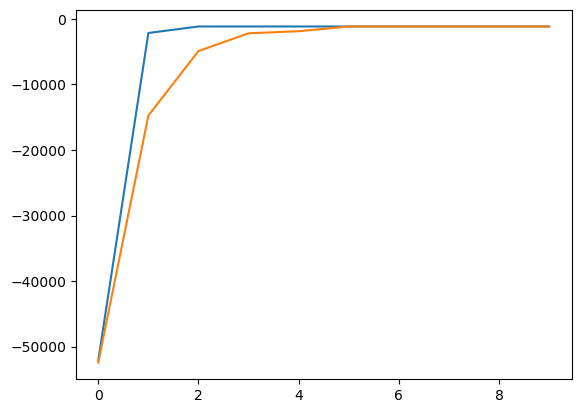

In [53]:
import matplotlib.pyplot as plt

maxs = [np.max(fits) for fits in history]
means = [np.mean(fits) for fits in history]

plt.plot(maxs)
plt.plot(means)
plt.show()

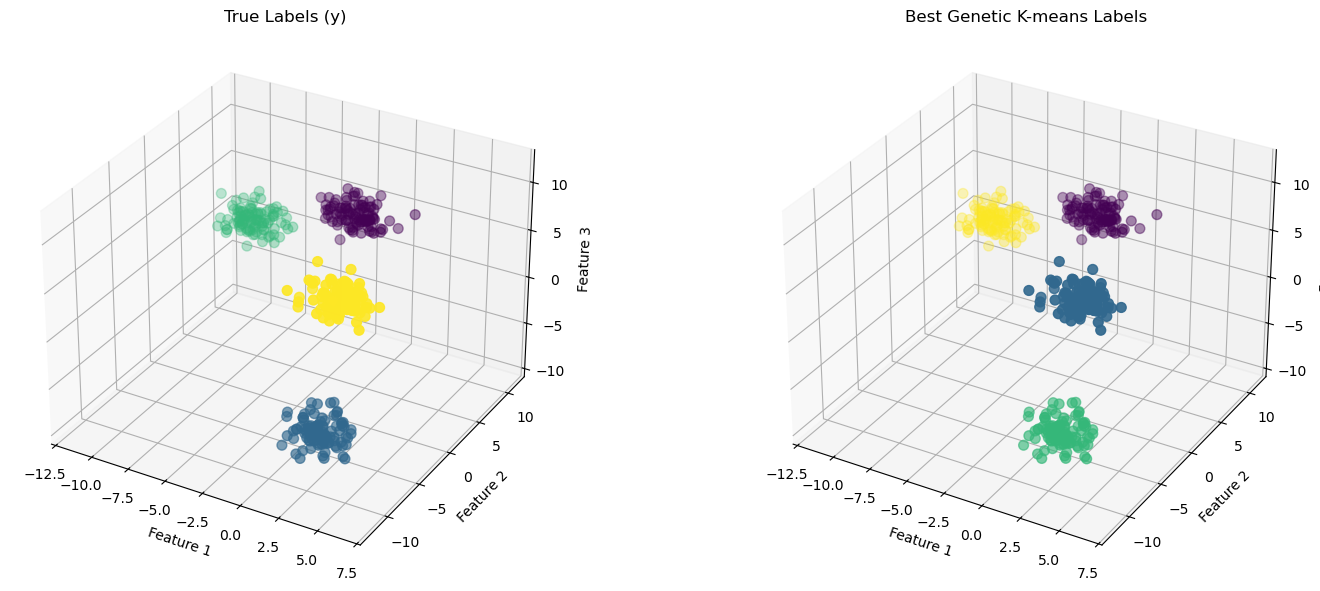

In [54]:
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
scatter1 = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', s=50)
ax1.set_title("True Labels (y)")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_zlabel("Feature 3")

best_labels = population[np.argmax(history[-1])]
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter2 = ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=best_labels, cmap='viridis', s=50)
ax2.set_title("Best Genetic K-means Labels")
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")
ax2.set_zlabel("Feature 3")

plt.tight_layout()
plt.show()